# Objective : 

1. Based on the latest topics presented, choose a dataset of your choice and create a Decision Tree where you can solve a classification problem and predict the outcome of a particular feature or detail of the data used.

2. Switch variables* to generate 2 decision trees and compare the results. Create a random forest and analyze the results.

3. Based on real cases where desicion trees went wrong, and 'the bad & ugly' aspects of decision trees (https://decizone.com/blog/the-good-the-bad-the-ugly-of-using-decision-trees), how can you change this perception when using the decision tree you created to solve a real problem?


***

# Data Cleaning / EDA

The [Airline Reviews and Rating](https://www.kaggle.com/datasets/anandshaw2001/airlines-reviews-and-rating) dataset from Kaggle was selected because this dataset allows for the tackling of a practical classification problem.  The combination of textual reviews and numerical ratings presents a chance to explore sentiment analysis and decision tree skills.

The target variable is the `Recommended` column where customer decide whether to recommed the airline based on their travel experience.

There 3 types of features: 

* numerical where the customer rates different aspects such as `Value for Money` or `Cabin Staff Service` on a scale of 1-5 where 5 is the best.

* categorical where the customer bought a economy or business class ticket.

* text where the customer wrote about their experience while traveling with certan airlines.

In [1]:
# load libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('c:/Users/nickc/DataScience/NickAMC.github.io/D622-S24/hw2/Airlines Reviews and Rating.csv')

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Seat Comfort,3176.0,2.833123,1.360588,1.0,2.0,3.0,4.0,5.0
Cabin Staff Service,3165.0,3.228752,1.486388,1.0,2.0,3.0,5.0,5.0
Ground Service,2812.0,2.795519,1.455301,1.0,1.0,3.0,4.0,5.0
Food & Beverages,2911.0,2.678461,1.435562,0.0,1.0,3.0,4.0,5.0
Wifi & Connectivity,592.0,1.923986,1.355305,1.0,1.0,1.0,3.0,5.0
Inflight Entertainment,2171.0,2.654537,1.386722,0.0,1.0,3.0,4.0,5.0
Value For Money,3290.0,2.636474,1.459832,1.0,1.0,3.0,4.0,5.0


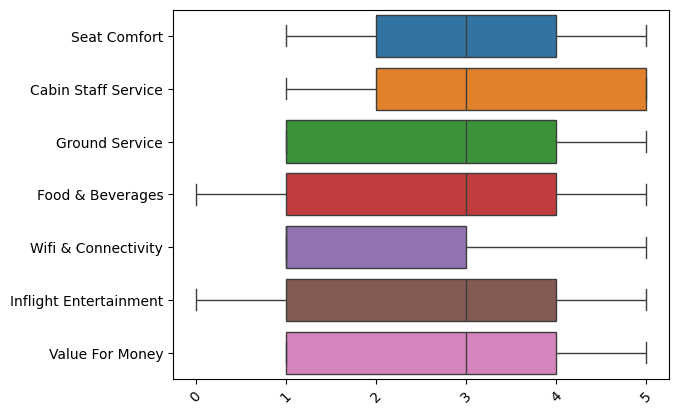

In [4]:
import seaborn as sns

sns.boxplot(data=df, orient='h')
plt.xticks(rotation=45)
plt.show()


In [5]:
df.head()

,Aircraft Type,Users Reviews,Country,Type_of_Travellers,Route,Seat_Types,Seat Comfort,Date Flown,Cabin Staff Service,Ground Service,Food & Beverages,Wifi & Connectivity,Inflight Entertainment,Value For Money,Recommended
0,NaN,✅Trip Verified| Cancelled our flight last-min...,United Kingdom,Couple Leisure,London Heathrow to Tokyo,Economy Class,1.0,Sep-23,1.0,2.0,1.0,NaN,3.0,1,no
1,NaN,"✅Trip Verified| I had a flight from Miami, Flo...",United States,Solo Leisure,Miami to Dublin via London Heathrow,Business Class,1.0,Aug-23,3.0,1.0,2.0,1.0,1.0,1,no
2,NaN,✅Trip Verified| We started our day with BA in...,United States,Business,Prague to San Francisco via London,Business Class,1.0,Sep-23,3.0,1.0,3.0,1.0,NaN,1,no
3,NaN,✅Trip Verified| I fly British Airways weekly ...,United Kingdom,Business,London to Glasgow,Economy Class,1.0,Sep-23,1.0,1.0,1.0,1.0,1.0,1,no
4,NaN,Not Verified| Everything was ok until our con...,France,Family Leisure,San Diego to Marseille via London,Economy Class,3.0,Aug-23,2.0,1.0,3.0,1.0,3.0,3,no


In [6]:
missing_values_count = df.isnull().sum().to_frame(name='Missing Values')
missing_values_count['Missing Percentage'] = (missing_values_count['Missing Values'] / len(df) * 100).round(2)

missing_values_count['Missing Percentage'] = missing_values_count['Missing Percentage'].round(2)
missing_values_count

,Missing Values,Missing Percentage
Aircraft Type,1394,42.37
Users Reviews,0,0.00
Country,1,0.03
Type_of_Travellers,403,12.25
Route,407,12.37
Seat_Types,3,0.09
Seat Comfort,114,3.47
Date Flown,410,12.46
Cabin Staff Service,125,3.80
Ground Service,478,14.53


Due to high proportion of missingness the columns `Aircraft Type` and `Wifi & Connectivity` will be dropped.

In [7]:
df.drop(['Aircraft Type', 'Wifi & Connectivity'], inplace = True, axis = 1)

Initially, I wanted to drop the user reviews column but I found the SIA function that quickly performs a sentiment analysis on the users reviews. 

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# use sentiment analysis base on column usersreview. output should positive 1 or negative 0
df['Review Sentiment'] = df['Users Reviews'].apply(lambda x: '1' if sia.polarity_scores(x)['compound'] >= 0.05 else '0')


In [9]:
df.drop(['Country', 'Users Reviews','Route', 'Date Flown'], axis = 1, inplace = True)

In [10]:
#  deal with the missingness
df = df.dropna()

In [11]:
df.isna().sum()

Type_of_Travellers        0
Seat_Types                0
Seat Comfort              0
Cabin Staff Service       0
Ground Service            0
Food & Beverages          0
Inflight Entertainment    0
Value For Money           0
Recommended               0
Review Sentiment          0
dtype: int64

There 4 unique `Seat_Types and `Type_of_Travellers`. We will need to use an encoder to convert these catogorical values to numeric. Initially, we tried using LabelEncoder() but it ran the risk of not treating the classes fairly. This may be true in the real-world but our DT model doesnt know that and its introduce unwanted bias. Thus, we ended up using OneHotEncoder() create binary columns indicate the whether or not it is that category.

In [12]:
df['Seat_Types'].unique().tolist()

['Economy Class', 'Business Class', 'Premium Economy', 'First Class']

In [13]:
df['Type_of_Travellers'].unique().tolist()


['Couple Leisure', 'Solo Leisure', 'Business', 'Family Leisure']

In [14]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['Seat_Types', 'Type_of_Travellers']

encoder = OneHotEncoder(handle_unknown='ignore')

encoded_data = encoder.fit_transform(df[categorical_columns]).toarray()

new_col_names = encoder.get_feature_names_out(categorical_columns)

df_encoded = pd.DataFrame(encoded_data, columns=new_col_names)

df_final = pd.concat([df.reset_index(), df_encoded],axis = 1) # concat requireds matching indices

In [15]:
df_final.drop(['index','Type_of_Travellers','Seat_Types'], axis = 1, inplace=True)

In [16]:
df_final.head()

,Seat Comfort,Cabin Staff Service,Ground Service,Food & Beverages,Inflight Entertainment,Value For Money,Recommended,Review Sentiment,Seat_Types_Business Class,Seat_Types_Economy Class,Seat_Types_First Class,Seat_Types_Premium Economy,Type_of_Travellers_Business,Type_of_Travellers_Couple Leisure,Type_of_Travellers_Family Leisure,Type_of_Travellers_Solo Leisure
0,1.0,1.0,2.0,1.0,3.0,1,no,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,3.0,1.0,2.0,1.0,1,no,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1,no,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,2.0,1.0,3.0,3.0,3,no,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,2.0,1.0,2.0,3.0,1,no,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [17]:
df_final.shape

(1739, 16)

Checking if the encoding created the desired outcome and not added unwanted NaN values.

In [18]:
df_final.isna().sum()

Seat Comfort                         0
Cabin Staff Service                  0
Ground Service                       0
Food & Beverages                     0
Inflight Entertainment               0
Value For Money                      0
Recommended                          0
Review Sentiment                     0
Seat_Types_Business Class            0
Seat_Types_Economy Class             0
Seat_Types_First Class               0
Seat_Types_Premium Economy           0
Type_of_Travellers_Business          0
Type_of_Travellers_Couple Leisure    0
Type_of_Travellers_Family Leisure    0
Type_of_Travellers_Solo Leisure      0
dtype: int64

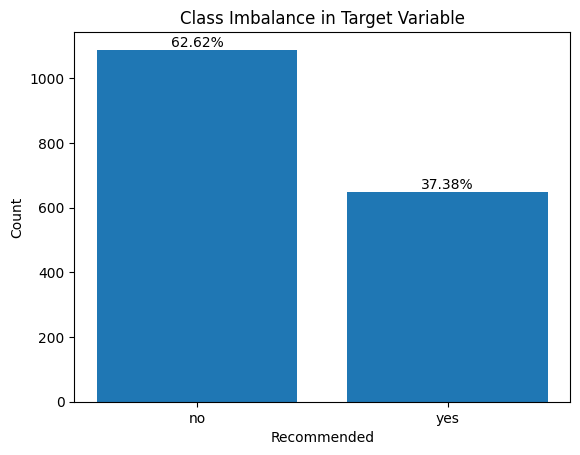

In [19]:
class_counts = df_final['Recommended'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Recommended')
plt.ylabel('Count')
plt.title('Class Imbalance in Target Variable')

total = sum(class_counts.values)
for i, count in enumerate(class_counts.values):
     percentage = count / total * 100
     plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()


We can tackle htis class imbalance in the train_test_split() where we will set the stratify argument equal to the target set. Although, DecisionTrees are relatively more robust to class imbalances than other ML models it is not immune to it.

In [20]:
X = df_final.drop('Recommended', axis=1)
y = df[['Recommended']]

In [21]:
X.shape, y.shape

((1739, 15), (1739, 1))

# Model Building

Now that we have cleaned, encoding, and assigned sentiment to the data. We can train and test our Decion Tree model.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [23]:
SEED = 123 

X_train,X_test,y_train, y_test = train_test_split(X,y, test_size =0.2, random_state= SEED, stratify=y )

## DecisionTree Model 1 : Normal

In [24]:
#  grid search to find the optimal parameters

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3,10),
    'min_samples_leaf': [0.1, 0.15,0.2, 0.25]  
 }

dt = DecisionTreeClassifier(random_state=SEED) 
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')  
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 0.1}


In [52]:
dt1 = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=0.1, random_state=SEED)

dt1.fit(X_train, y_train)

y_pred  = dt1.predict(X_test)
print(f'DT Model 1 Accuracy: {accuracy_score(y_test, y_pred):.3%}')


DT Model 1 Accuracy: 90.805%


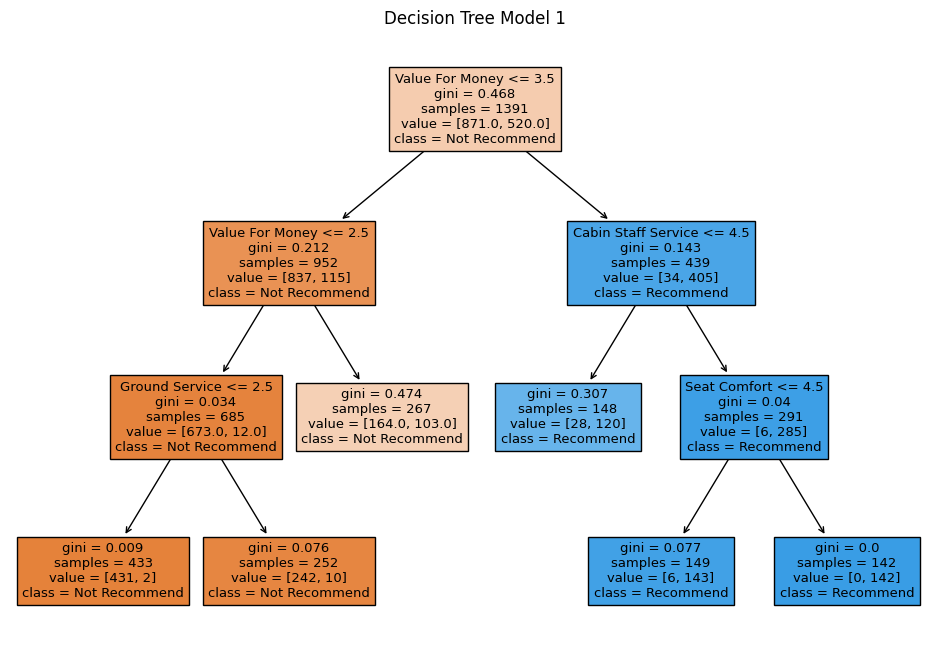

In [26]:
from sklearn import tree

plt.figure(figsize=(12, 8))
tree.plot_tree(dt, feature_names=X_train.columns, class_names=['Not Recommend', 'Recommend'], filled=True)
plt.title('Decision Tree Model 1')
plt.show()


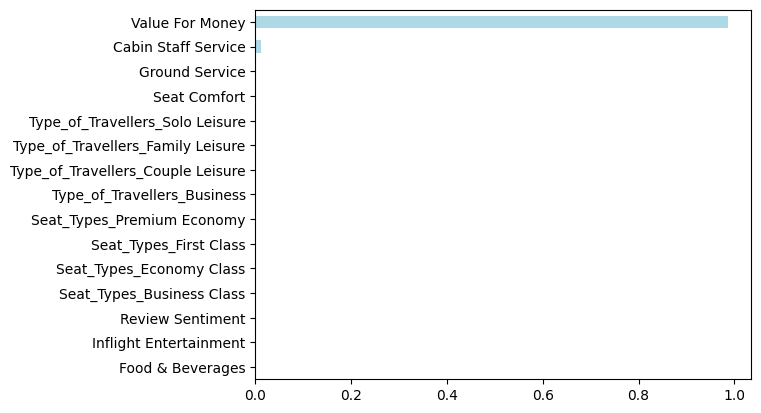

In [27]:
importance_dt = pd.Series(dt.feature_importances_, index = X_train.columns)

importance_sorted_dt = importance_dt.sort_values()

importance_sorted_dt.plot(kind='barh', color = 'blue')
plt.show()

The analysis revealed `Value for Money` was the most influential feature in this decision tree moidel. This demonstrates the customer-service nature of airline recommendations. Customers seems to prioritize the feeling value of their ticket-price relateive to their travel experience, such as cabin service and seat comfort.

## DecisionTree Model 2 : Forced Split

Purposely removing the initial splitting feature of the decision tree will result in a structurally different model. This was achieved by preventing the previously top-ranked feature from being used in the first split of the firstmodel.

In [28]:
X_train_2 = X_train.drop('Value For Money', axis =1)
X_test_2 = X_test.drop('Value For Money', axis =1) # almost forgot about X_test :)

Then, we create another model without `Value for Money` and see it if its predictive power changes significantly. We could run the GridSearchCV() again to see the best parameters for the truncated X_train. For now, lets stick to the parameters from the first DT model.

In [74]:
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=0.1, random_state=SEED)

dt2.fit(X_train_2, y_train)

y_pred2  = dt2.predict(X_test_2)
print(f'DT Model 2 Accuracy: {accuracy_score(y_test, y_pred2):.3%}')


DT Model 2 Accuracy: 87.356%


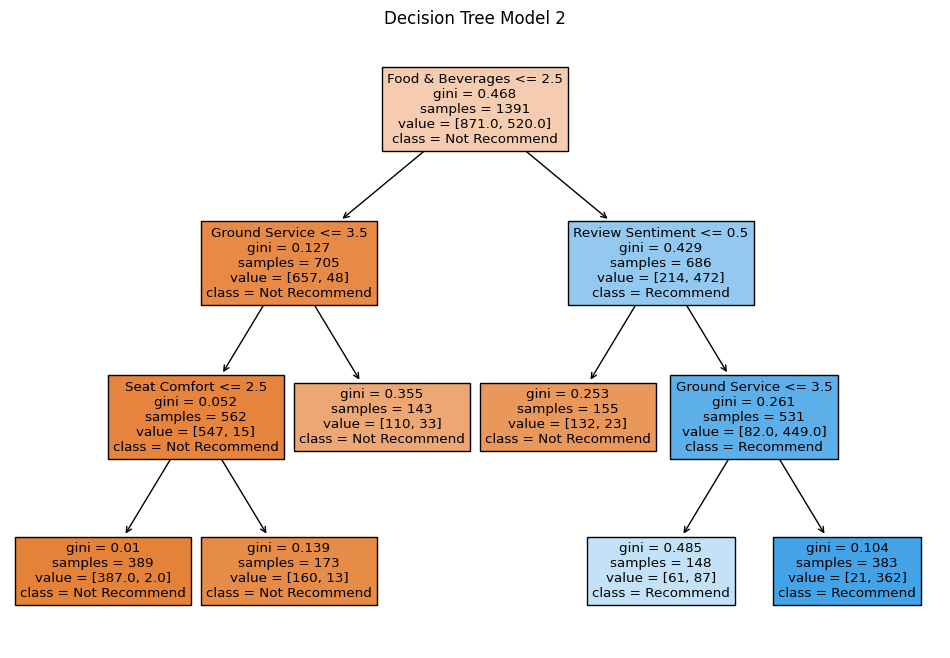

In [30]:
plt.figure(figsize=(12, 8))
tree.plot_tree(dt2, feature_names=X_train_2.columns, class_names=['Not Recommend', 'Recommend'], filled=True)
plt.title('Decision Tree Model 2')
plt.show()

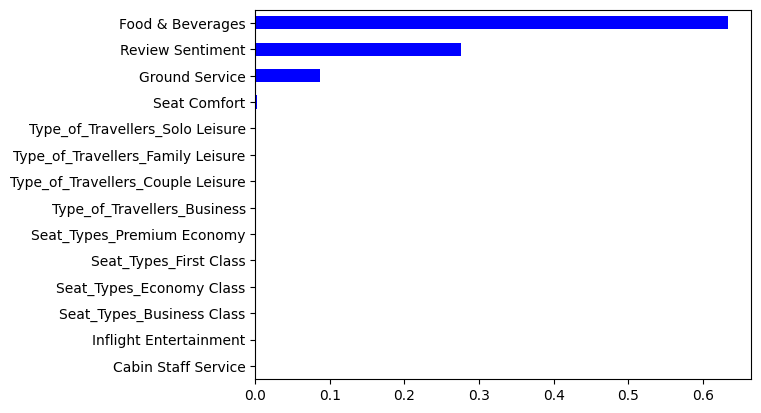

In [43]:
importance_dt = pd.Series(dt2.feature_importances_, index = X_train_2.columns)

importance_sorted_dt = importance_dt.sort_values()

importance_sorted_dt.plot(kind='barh', color = 'blue')
plt.show()

Excluding the most influential feature, `Value for Money`, led to a 3% drop in model accuracy. This highlights the significant explanatory power of 'Value for Money' in predicting airline recommendations.

## Random Forest Model

Utilized Grid Search and cross validation to find the optimal paramaters to use for the Random Forest model.

In [32]:
#| warning : false
#| message : false

param_grid_rf = {
     'n_estimators': [50, 100, 200, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3,10),
    'min_samples_leaf': [0.05, 0.1,0.15, 0.18]  
 }

rf = RandomForestClassifier(random_state=SEED)

gs_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=5, scoring = 'accuracy', n_jobs=-1)
gs_rf.fit(X_train, y_train)

best_params = gs_rf.best_params_
print(best_params)


c:\Users\nickc\DataScience\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 0.05, 'n_estimators': 400}


In [34]:
#| warning : false
#| message : false

rf = RandomForestClassifier(n_estimators = 400, criterion='entropy',max_depth=4, min_samples_leaf=0.05)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

print(f'RandomForestClassifier Model Accuracy: {accuracy_score(y_test, y_pred_rf):.3%}')

c:\Users\nickc\DataScience\.venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier Model Accuracy: 92.816%


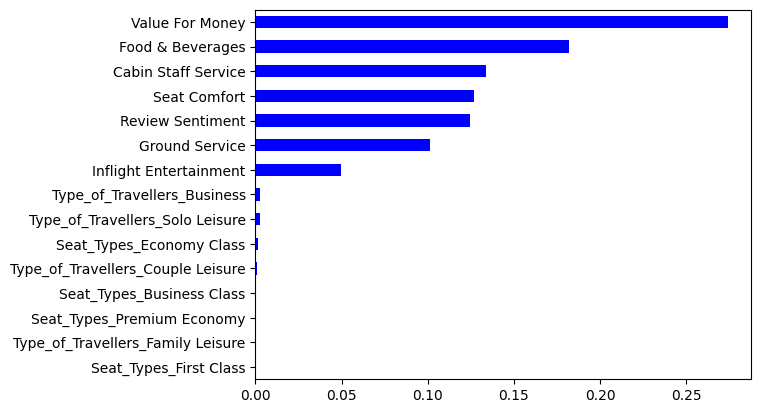

In [42]:
importance_rf = pd.Series(rf.feature_importances_, index = X_train.columns)

importance_sorted_rf = importance_rf.sort_values()

importance_sorted_rf.plot(kind='barh', color = 'blue')
plt.show()

# Model Variance Analysis

In [44]:
from sklearn.model_selection import cross_val_score

In [62]:
cross_val_score(dt1,X_train,y_train, cv=10, scoring ='accuracy', n_jobs=-1)

array([0.84285714, 0.89208633, 0.90647482, 0.89208633, 0.88489209,
       0.9352518 , 0.89928058, 0.8705036 , 0.90647482, 0.89928058])

In [71]:
# DT Model 1 
acc_CV_scores = cross_val_score(dt1,X_train,y_train, cv=10, scoring ='accuracy', n_jobs=-1)
mean_cv = acc_CV_scores.mean()
print(f'CV Mean Accuracy for DT Model 1: {mean_cv:.3%}')

# DT Model 2
acc_CV_scores = cross_val_score(dt2,X_train_2,y_train, cv=10, scoring ='accuracy', n_jobs=-1)
mean_cv = acc_CV_scores.mean()
print(f'CV Mean Accuracy for DT Model 2: {mean_cv:.3%}')


# RandomForest
acc_CV_scores = cross_val_score(rf,X_train,y_train, cv=10, scoring ='accuracy', n_jobs=-1)
mean_cv = acc_CV_scores.mean()
print(f'CV Mean Accuracy for RF Model: {mean_cv:.3%}')

CV Mean Accuracy for DT Model 1: 89.292%
CV Mean Accuracy for DT Model 2: 85.044%
CV Mean Accuracy for RF Model: 92.672%


Recall, Accuracy from training set:

In [75]:
print(f'DT Model 1 Accuracy: {accuracy_score(y_test, y_pred):.3%}')
print(f'DT Model 2 Accuracy: {accuracy_score(y_test, y_pred2):.3%}')
print(f'RandomForestClassifier Model Accuracy: {accuracy_score(y_test, y_pred_rf):.3%}')

DT Model 1 Accuracy: 90.805%
DT Model 2 Accuracy: 87.356%
RandomForestClassifier Model Accuracy: 92.816%


The RF Classifier models demonstrates the highest accuracy on both the training set and the CV results. This is expected from a ensemble model since its reduces vairance and mitigate overfitting relative to a single DecisionTree. Moreover, there is slight drop in accuracy between training and CV scores for all of the models. This suggests a small degree of overfitting.

DT model 2 show the largest difference in scores indicating that DT model 2 is more likely to overfit and have a higher variance on the training set. 

In response to the blog, to counter over-fitting the model to the data we used cross-validation and limited paramaters such max_depth to retain the models interpretability as model complexity was mentioned in the blog. Moreover, a random forest model further mitigates the variability by taking the average across a number of decision trees. 

In terms of practical applications, from this airline reviews data. Company stackholders can look at the feature importance chart and focues on the Value for Money being above a certain value return a favorable outcome to the company. This is easily understood and be used as evidence to decide company policies. 

Another aspect from the blog of metrics relevant, is that we retrain the our models at intervales to adapt the shift in customer opinion or value in order to for the models to relevant.

# Resources

DataCamp : [ML with Tree-Based Models in Python Module](https://app.datacamp.com/learn/courses/machine-learning-with-tree-based-models-in-python)

https://scikit-learn.org/